# Fifth Stage

In [1]:
import sys
sys.path.append('..')
from flash_order import *
from matplotlib.ticker import MaxNLocator

In [2]:
target_stock_code = '0050'
foc = FlashOrderCalculator(target_stock_code)

2022-12-26 16:02:50.058 | INFO     | get_data.py         :   36 | Got cache at /Users/anthonywah/Projects/mafs6100-order-placement-strategy/cache/0050.pkl - 12.12s


---

### 1) Flash Order Spectrum

In [3]:
foc.classify(max_dur_ms=100, trick_trade_thres_ms=100)

ClassifyingFlashOrder: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:10<00:00, 16.73it/s]


Text(0.5, 1.0, 'Distribution of Flash Order Duration')

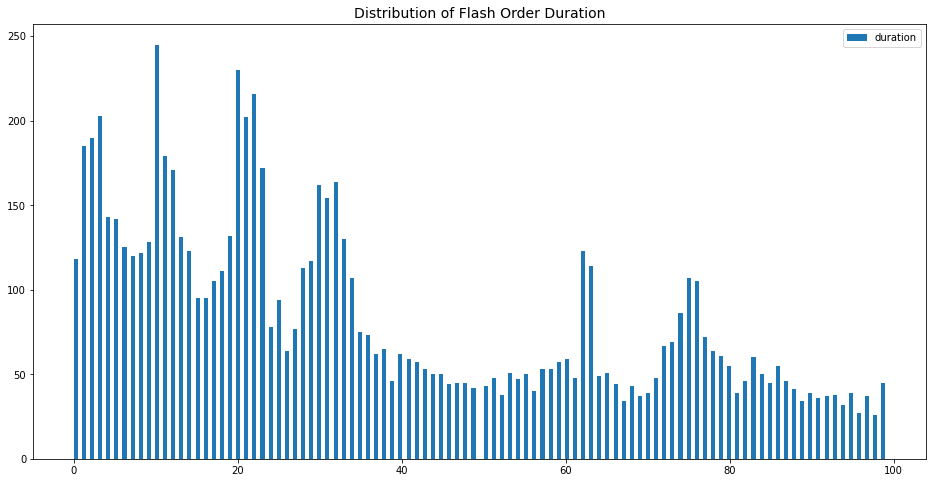

In [4]:
fig,ax = plt.subplots(figsize=(16,8))
ax.hist([i['duration'] for i in foc.fod[100][100]], bins=200, label='duration')
ax.legend(loc = 'upper right')
ax.set_title('Distribution of Flash Order Duration', fontsize=14)

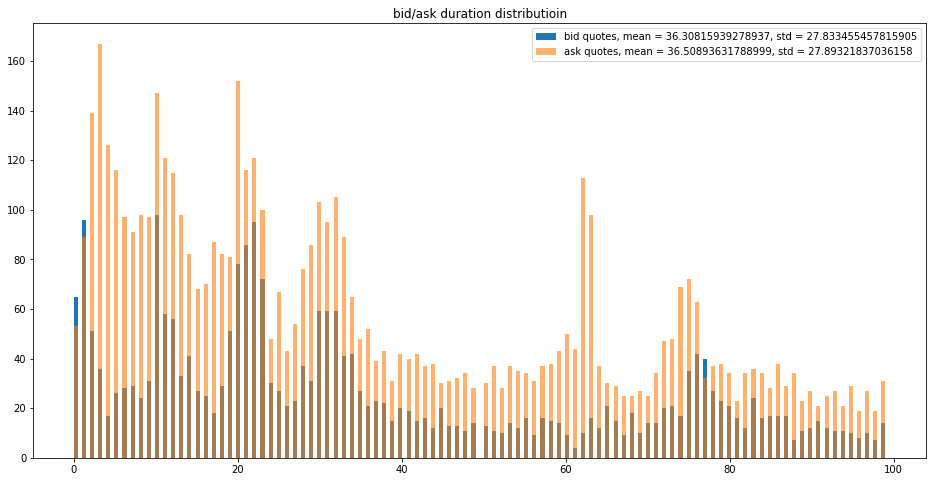

In [16]:
bid_dur = []
ask_dur = []
for item in foc.fod[100][100]:
    if item['side'] == 'bid':
        bid_dur.append(item['duration'])
    elif item['side'] == 'ask':
        ask_dur.append(item['duration'])
fig, ax = plt.subplots(figsize = (16,8))
ax.hist(bid_dur, bins = 200, label =f'bid quotes, mean = {np.mean(bid_dur)}, std = {np.std(bid_dur)}')
ax.hist(ask_dur, bins = 200, label =f'ask quotes, mean = {np.mean(ask_dur)}, std = {np.std(ask_dur)}', alpha = 0.6)
ax.set_title('bid/ask duration distributioin')
ax.legend(loc = 'upper right')

---

### 2) Flash Order Size

Text(0.5, 1.0, 'Distribution of Flash Order Quantity')

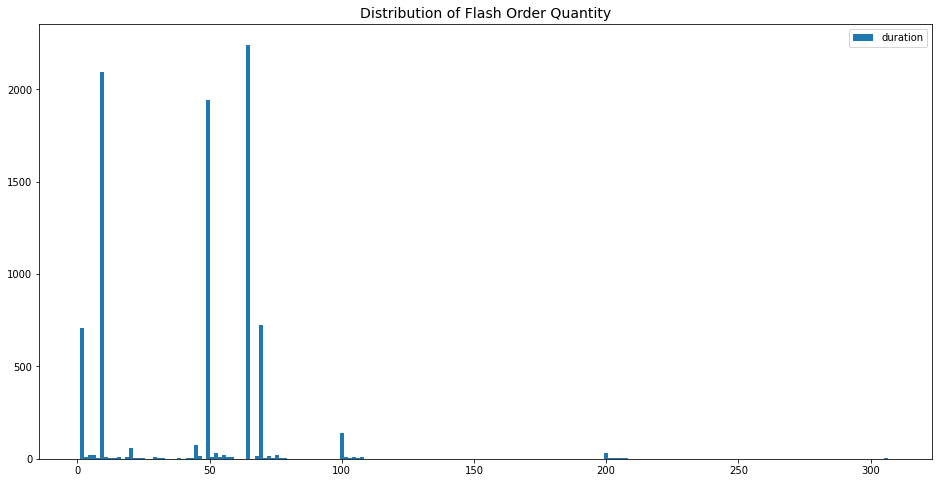

In [5]:
fig,ax = plt.subplots(figsize=(16,8))
ax.hist([i['fo_qty'] for i in foc.fod[100][100]], bins=200, label='duration')
ax.legend(loc = 'upper right')
ax.set_title('Distribution of Flash Order Quantity', fontsize=14)

---

### 3) Intra-day Pattern of Flash Orders

MatchingFlashOrderIndex: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8398/8398 [00:00<00:00, 68978.56it/s]


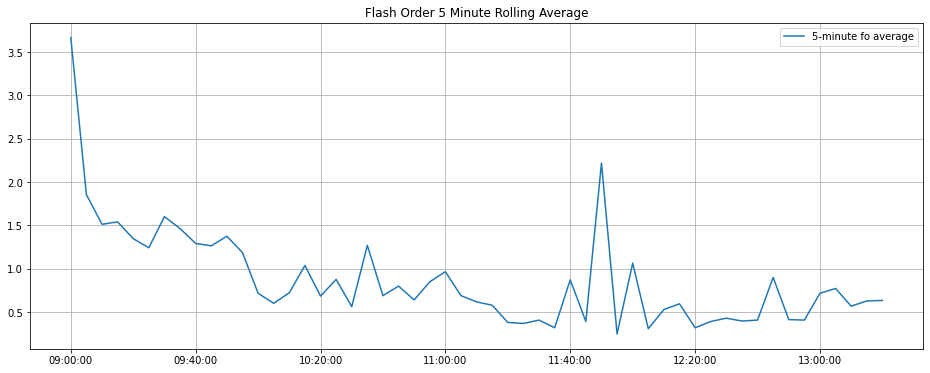

In [6]:
data_gb_cp = {k: v.assign(IS_FO=0) for k, v in foc.data_gb.items()}

for case in tqdm.tqdm(foc.fod[100][100], ncols=200, desc='MatchingFlashOrderIndex', total=len(foc.fod[100][100])):
    data_gb_cp[case['date']].at[case['start_index'], 'IS_FO'] = 1

all_df = pd.concat(list(data_gb_cp.values())).reset_index(drop=True)
all_df.loc[:, '5m_bin'] = all_df['dt'].dt.floor(freq='5min').dt.time.astype(str)
df_bin = all_df.groupby('5m_bin')[['IS_FO']].sum().reset_index()

# Start plotting
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_title('Flash Order 5 Minute Rolling Average')
ax.plot(df_bin['5m_bin'], df_bin['IS_FO'] / len(data_gb_cp), label='5-minute fo average')
locator = MaxNLocator(prune='both', nbins=8)
ax.xaxis.set_major_locator(locator)
ax.grid(True)
ax.legend()
plt.show()

MatchingFlashOrderIndex: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8398/8398 [00:00<00:00, 59129.54it/s]


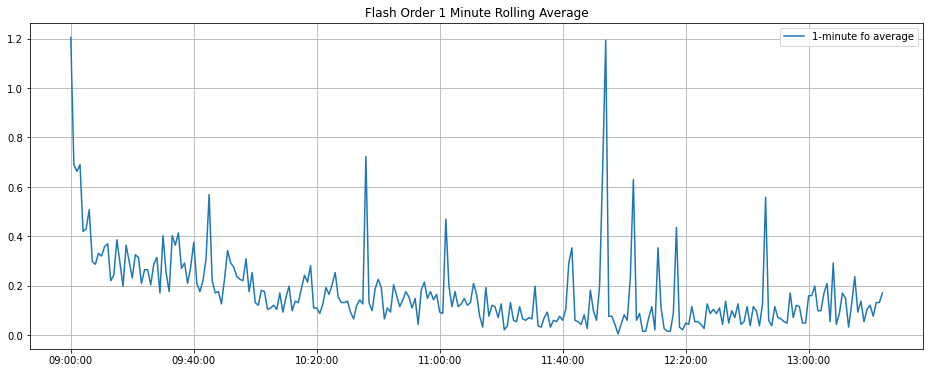

In [7]:
data_gb_cp = {k: v.assign(IS_FO=0) for k, v in foc.data_gb.items()}

for case in tqdm.tqdm(foc.fod[100][100], ncols=200, desc='MatchingFlashOrderIndex', total=len(foc.fod[100][100])):
    data_gb_cp[case['date']].at[case['start_index'], 'IS_FO'] = 1

all_df = pd.concat(list(data_gb_cp.values())).reset_index(drop=True)
all_df.loc[:, '1m_bin'] = all_df['dt'].dt.floor(freq='1min').dt.time.astype(str)
df_bin = all_df.groupby('1m_bin')[['IS_FO']].sum().reset_index()

# Start plotting
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_title('Flash Order 1 Minute Rolling Average')
ax.plot(df_bin['1m_bin'], df_bin['IS_FO'] / len(data_gb_cp), label='1-minute fo average')
locator = MaxNLocator(prune='both', nbins=8)
ax.xaxis.set_major_locator(locator)
ax.grid(True)
ax.legend()
plt.show()

---

### 4) Success Rate of Flash Orders

In [8]:
check_thres_ls = list(range(100, 501, 50))
for i in check_thres_ls:
    foc.classify(max_dur_ms=100, trick_trade_thres_ms=i)

2022-12-26 16:03:46.696 | INFO     | flash_order.py      :   40 | Classification of max_dur_ms=100 & trick_trade_thres_ms=100 done already
ClassifyingFlashOrder: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [00:11<00:00, 15.12it/s]


In [9]:
for k in check_thres_ls:
    success_rate = len([i for i in foc.fod[100][k] if i['tricked_trade']]) / len(foc.fod[100][k])
    print(f'{target_stock_code} - Success rate of Tricked Trades in {k}ms  - {100 * success_rate:.2f}%')
    opp_success_rate = len([i for i in foc.fod[100][k] if i['opp_tricked_trade']]) / len(foc.fod[100][k])
    print(f'{target_stock_code} - Success rate of Opposite Tricked Trades in {k}ms  - {100 * opp_success_rate:.2f}%')

0050 - Success rate of Tricked Trades in 100ms  - 0.85%
0050 - Success rate of Opposite Tricked Trades in 100ms  - 1.85%
0050 - Success rate of Tricked Trades in 150ms  - 1.17%
0050 - Success rate of Opposite Tricked Trades in 150ms  - 2.48%
0050 - Success rate of Tricked Trades in 200ms  - 1.46%
0050 - Success rate of Opposite Tricked Trades in 200ms  - 3.07%
0050 - Success rate of Tricked Trades in 250ms  - 1.81%
0050 - Success rate of Opposite Tricked Trades in 250ms  - 3.75%
0050 - Success rate of Tricked Trades in 300ms  - 2.13%
0050 - Success rate of Opposite Tricked Trades in 300ms  - 4.38%
0050 - Success rate of Tricked Trades in 350ms  - 2.42%
0050 - Success rate of Opposite Tricked Trades in 350ms  - 5.10%
0050 - Success rate of Tricked Trades in 400ms  - 2.69%
0050 - Success rate of Opposite Tricked Trades in 400ms  - 5.69%
0050 - Success rate of Tricked Trades in 450ms  - 2.96%
0050 - Success rate of Opposite Tricked Trades in 450ms  - 6.38%
0050 - Success rate of Tricked T

In [10]:
print([i['case_index'] for i in foc.fod[100][100] if i['opp_tricked_trade']][:15])

[3, 13, 35, 167, 175, 270, 279, 294, 337, 376, 377, 387, 388, 403, 404]


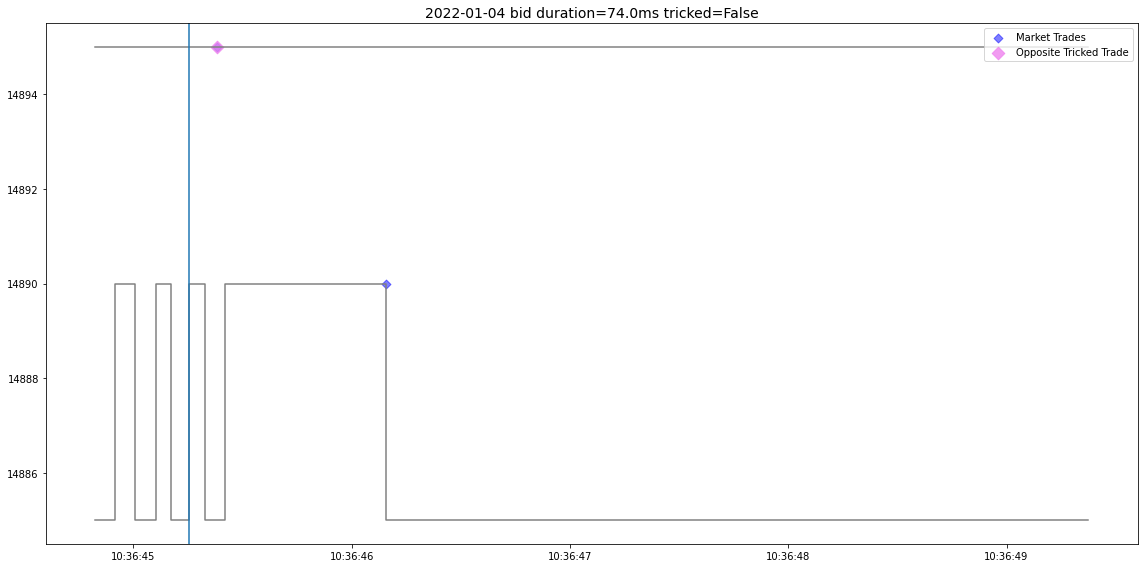

In [11]:
foc.plot_quote(100, 100, 167)

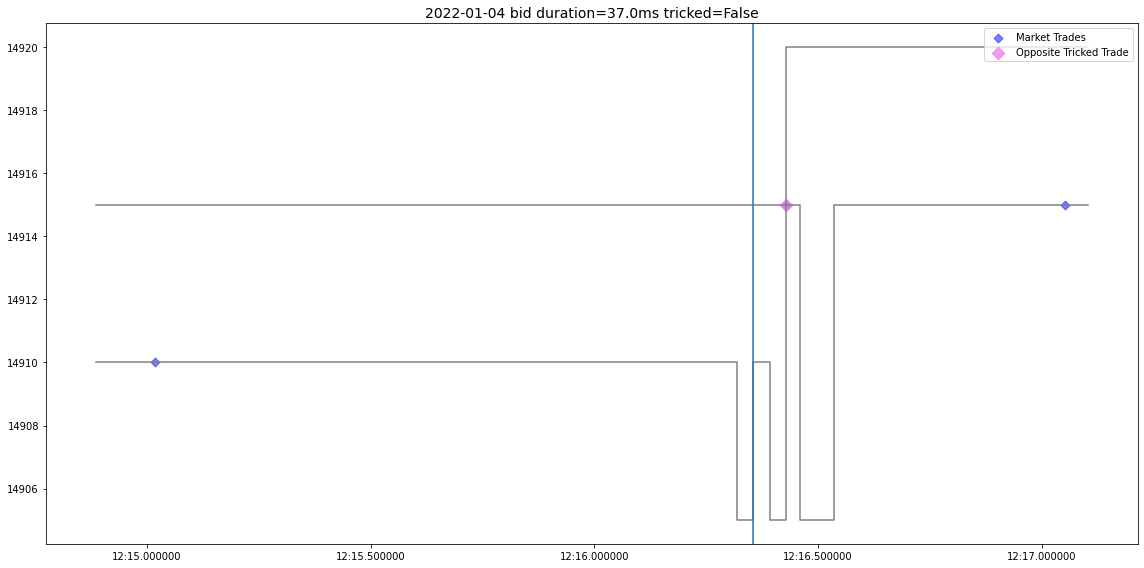

In [12]:
foc.plot_quote(100, 100, 175)

---

### 5) Flickering Quote Impact

In [13]:
bid_influ, ask_influ = [], []
for i in range(1, 31):
    bid_mv, ask_mv = foc.get_flick_influ(fo_dur=100, decay=i)
    bid_influ.append(bid_mv)
    ask_influ.append(ask_mv)

100%|██████████| 8398/8398 [00:18<00:00, 466.20it/s]


Text(0, 0.5, 'mean of return')

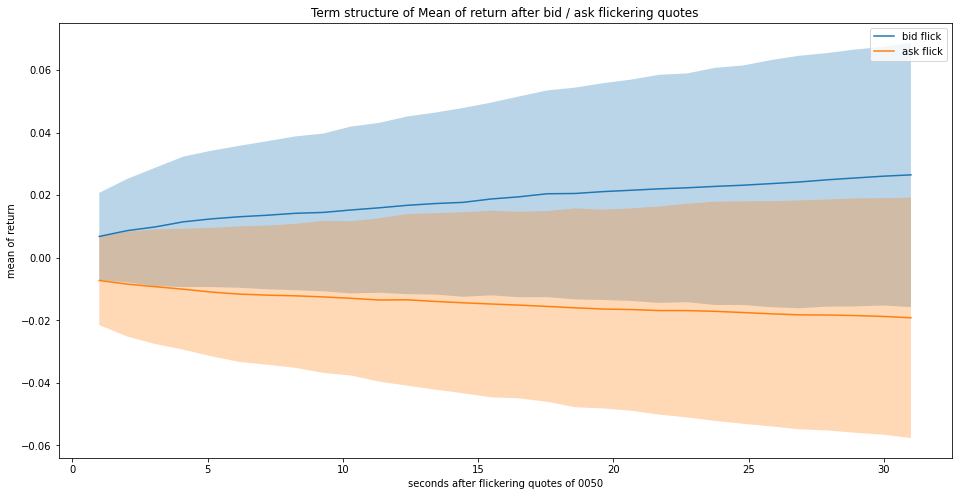

In [14]:
## plotting

fig, ax = plt.subplots(figsize = (16, 8))
x_bid = np.array([np.mean(bid_mv) for bid_mv in bid_influ])
s_bid = np.array([np.std(bid_mv) for bid_mv in bid_influ])
ax.plot(np.linspace(1,31,30), x_bid, label = 'bid flick')
ax.fill_between(np.linspace(1,31,30),x_bid-s_bid,x_bid+s_bid, alpha = 0.3)
x_ask = np.array([np.mean(ask_mv) for ask_mv in ask_influ])
s_ask = np.array([np.std(ask_mv) for ask_mv in ask_influ])
ax.plot(np.linspace(1,31,30), x_ask, label = 'ask flick')
ax.fill_between(np.linspace(1,31,30),x_ask-s_ask,x_ask+s_ask, alpha = 0.3)
ax.legend(loc = 'upper right')
ax.set_title('Term structure of Mean of return after bid / ask flickering quotes')
ax.set_xlabel(f'seconds after flickering quotes of {target_stock_code}')
ax.set_ylabel('mean of return')

---